
# <span style="color:#D4AF37;">Energy Prediction Model</span>


## Introduction
### Overview

Assessing the value of energy efficiency improvements can be challenging as there's no way to truly know how much energy a building would have used without the improvements. The best we can do is to build counterfactual models. Once a building is overhauled the new (lower) energy consumption is compared against modeled values for the original building to calculate the savings from the retrofit. More accurate models could support better market incentives and enable lower cost financing.

In this project, we will build these models across four energy types based on historic usage rates and observed weather. The dataset includes three years of hourly meter readings from over one thousand buildings at several different sites around the world.

# Data we used
https://www.kaggle.com/competitions/ashrae-energy-prediction/data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline

## Exploring "building_metadata.csv" file

In [3]:
#Load data
file_name = 'building_metadata.csv'
building_df = pd.read_csv(file_name)
building_df.head(10)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
5,0,5,Education,8000,2000.0,NaN
6,0,6,Lodging/residential,27926,1981.0,NaN
7,0,7,Education,121074,1989.0,NaN
8,0,8,Education,60809,2003.0,NaN
9,0,9,Office,27000,2010.0,NaN


In [4]:
building_df.shape

(1449, 6)

In [5]:
# Check for missing or null values
building_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [6]:
#Finding the precentage of missing value in this two columns 
floor_count_missing = 100*(building_df.floor_count.isna().sum()/len(building_df))
year_build_missing = 100*(building_df.year_built.isna().sum()/len(building_df))

print("Percentage of missing values in floor_count column is ", floor_count_missing, "%")
print("Percentage of missing values in year_build column is ", year_build_missing, "%")

Percentage of missing values in floor_count column is  75.50034506556246 %
Percentage of missing values in year_build column is  53.41614906832298 %


In [7]:
#After getting the precentage we found that more than half of their values are missing,
#these two features are not going to be particularly useful. So, we will drop them

building_df.drop(['floor_count', 'year_built'], axis=1, inplace=True)
building_df
                 

,site_id,building_id,primary_use,square_feet
0,0,0,Education,7432
1,0,1,Education,2720
2,0,2,Education,5376
3,0,3,Education,23685
4,0,4,Education,116607
...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619
1445,15,1445,Education,4298
1446,15,1446,Entertainment/public assembly,11265
1447,15,1447,Lodging/residential,29775


In [8]:
    #Check for duplicate values
building_df.duplicated().sum()

0

In [9]:
building_df['site_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

In [10]:
building_df['building_id'].unique()

array([   0,    1,    2, ..., 1446, 1447, 1448], dtype=int64)

<AxesSubplot:xlabel='site_id', ylabel='count'>

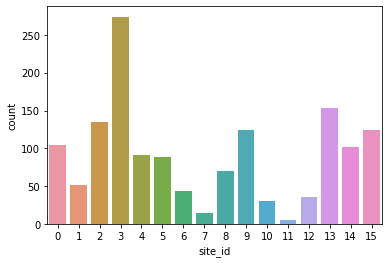

In [11]:
#Plot to represent number of buildings in every site
sb.countplot(x='site_id', data=building_df)

In [12]:
#Number of buildings in every primary_use
building_df['primary_use'].value_counts()

Education                        549
Office                           279
Entertainment/public assembly    184
Public services                  156
Lodging/residential              147
Other                             25
Healthcare                        23
Parking                           22
Warehouse/storage                 13
Manufacturing/industrial          12
Retail                            11
Services                          10
Technology/science                 6
Food sales and service             5
Utility                            4
Religious worship                  3
Name: primary_use, dtype: int64

In [13]:
#Mean Of square_feet by primary_use
building_df.groupby('primary_use').square_feet.agg(['mean'])

,mean
primary_use,
Education,104329.000000
Entertainment/public assembly,80584.070652
Food sales and service,38485.000000
Healthcare,140480.869565
Lodging/residential,85368.605442
Manufacturing/industrial,41120.833333
Office,87065.627240
Other,31456.560000
Parking,279341.772727


## Exploring "train.csv" file

In [14]:
file_name = 'train.csv'
train_dataframe = pd.read_csv(file_name)
#the train dataset contains a 'timestamp' column we convert to a datetime object for ease of use
train_dataframe['timestamp'] = pd.to_datetime(train_dataframe['timestamp']) 
train_dataframe.head(5)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [15]:
#summary of a train data
train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int64         
 1   meter          int64         
 2   timestamp      datetime64[ns]
 3   meter_reading  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 616.9 MB


In [16]:
#the sum of the null values 
train_dataframe.isna().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [17]:
# dimensionality of the train data.
print(train_dataframe.shape)

(20216100, 4)


In [18]:
# statistical details about train data
train_dataframe.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [19]:
print(train_dataframe["timestamp"].min() , train_dataframe["timestamp"].max(),sep ="\n")

2016-01-01 00:00:00
2016-12-31 23:00:00


In [20]:
# statistical details about meter_reading
train_dataframe['meter_reading'].describe()

count    2.021610e+07
mean     2.117121e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

In [21]:
zeros = train_dataframe[train_dataframe['meter_reading']== 0].shape[0] / train_dataframe.shape[0]
print('Zero reading percentile : {}'.format(round(zeros,3)))

Zero reading percentile : 0.093


The reading value is zero in 9% of the time. Those data might be absent because no energy usage makes no sense!

In [22]:
#converting the meters to what they stand for 
train_dataframe['meter'].replace({0:"electricity",1:"chilledwater",2:"steam",3:"hotwater"},inplace=True)

Text(0.5, 1.0, 'Meters percentage having zero readings')

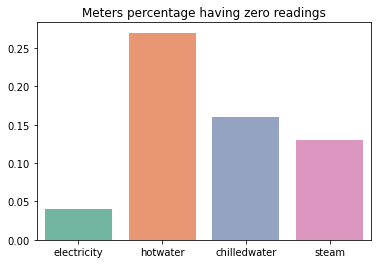

In [23]:
# to show the precentage of meters that having zeroes 
meter_dict = {}
for i in train_dataframe["meter"].unique():
    percent = round(train_dataframe[train_dataframe['meter_reading']== 0]["meter"].value_counts()[i] /train_dataframe["meter"].value_counts()[i],2)
    meter_dict[i] = percent
zero_meter = pd.Series(meter_dict)
sb.barplot(x=zero_meter.index, y= zero_meter,palette ="Set2")
plt.title("Meters percentage having zero readings")

In [24]:
train_dataframe["month"] = train_dataframe.timestamp.dt.month

Text(0.5, 1.0, 'For hot water')

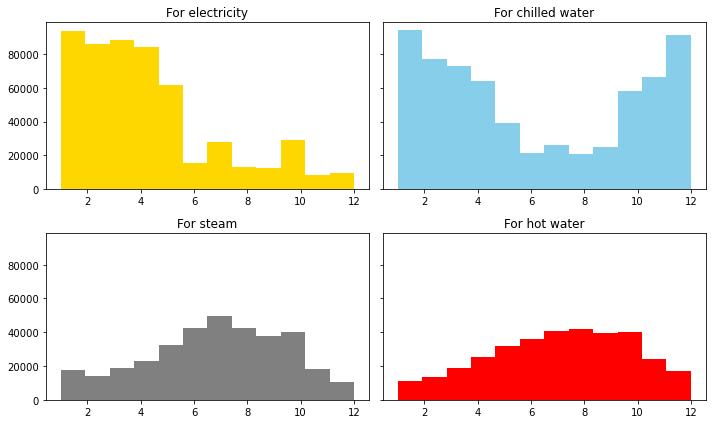

In [25]:
fig, axs = plt.subplots(2,2, sharey=True, tight_layout=True,figsize=(10,6))

axs[0][0].hist(x ="month",data =train_dataframe[(train_dataframe.meter_reading == 0) & (train_dataframe.meter=="electricity")],bins =12,color = "gold")
axs[0][0].set_title("For electricity")

axs[0][1].hist(x ="month",data =train_dataframe[(train_dataframe.meter_reading == 0) & (train_dataframe.meter=="chilledwater")],bins =12,color = "skyblue")
axs[0][1].set_title("For chilled water")

axs[1][0].hist(x ="month",data =train_dataframe[(train_dataframe.meter_reading == 0) & (train_dataframe.meter=="steam")],bins =12,color = "gray")
axs[1][0].set_title("For steam")

axs[1][1].hist(x ="month",data =train_dataframe[(train_dataframe.meter_reading == 0) & (train_dataframe.meter=="hotwater")],bins =12,color = "red")
axs[1][1].set_title("For hot water")

As seen in the graphs, zero readings vary with time and meter type. The first five months of the year have witnessed electricity meter zeros. The number of zero readings decreases as the month progresses. Seasonal variations in chilled and hot water zeros can be found. The distribution of zeros in steam and hot water is remarkably similar.

In [26]:
# Function for remove Outlier
def removeOutliers(data, outlierConstant = 1.5):
    values = np.array(data)
    upper_quartile = np.percentile(values, 75)
    lower_quartile = np.percentile(values, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartile = (lower_quartile - IQR, upper_quartile + IQR)
    results = []
    for i in values.tolist():
        if i >= quartile[0] and i <= quartile[1]:
            results.append(i)
    return results

In [27]:
target_noOutlier = removeOutliers(train_dataframe.meter_reading)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Original target distribution
sb.kdeplot(train_dataframe.meter_reading, ax=axes[0])
axes[0].set_title("Target distribution")

# Target distribution without outliers
sb.kdeplot(target_noOutlier, ax=axes[1])
axes[1].set_title("Target distribution without outlier")

# Target with log transform
sb.kdeplot(np.log1p(train_dataframe.meter_reading), ax=axes[2])
axes[2].set_title("Target with Log Transform")

In [28]:
train_dataframe['meter_reading_log'] = np.log1p(train_dataframe['meter_reading'])

The meter reading variable is highly right-skewed, with a large number of zeros. A skewed distribution is transformed into a more normalized dataset via logarithmic transformation. We have outliers in addition to zeros readings!

<AxesSubplot:xlabel='meter', ylabel='count'>

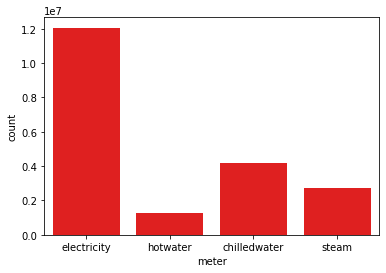

In [29]:
sb.countplot(x= "meter",data = train_dataframe,color = 'r')

In [ ]:
#Graphs shows distribution meter_reading in each meter category

sb.kdeplot(train_dataframe.loc[(train_dataframe['meter']=='electricity'), 
            "meter_reading_log"], color='yellow', shade=False, label='electricity')

sb.kdeplot(train_dataframe.loc[(train_dataframe['meter']=='chilledwater'), 
            "meter_reading_log"], color='b', shade=False, label='chilledwater')

sb.kdeplot(train_dataframe.loc[(train_dataframe['meter']=='steam'), 
            "meter_reading_log"], color='gray', shade=False, label='steam')

sb.kdeplot(train_dataframe.loc[(train_dataframe['meter']=='hotwater'), 
            "meter_reading_log"], color='r', shade=False, label='hotwater')

plt.xlabel('meter_reading_log') 
plt.ylabel('Probability Density')
plt.legend()

In [30]:
#sample data
sample_df = train_dataframe.sample(frac =.75)
sample_df

,building_id,meter,timestamp,meter_reading,month,meter_reading_log
2196076,916,steam,2016-02-09 19:00:00,106.7500,2,4.679814
5264821,421,electricity,2016-04-09 15:00:00,58.1400,4,4.079908
8738456,1051,electricity,2016-06-10 09:00:00,75.0825,6,4.331818
813346,1054,electricity,2016-01-15 18:00:00,479.0050,1,6.173797
9186301,952,electricity,2016-06-18 08:00:00,184.0000,6,5.220356
...,...,...,...,...,...,...
2347049,1214,electricity,2016-02-12 18:00:00,397.5730,2,5.987891
2247603,1126,electricity,2016-02-10 18:00:00,242.6290,2,5.495647
5987223,1115,electricity,2016-04-22 11:00:00,49.0240,4,3.912503
4729720,1340,electricity,2016-03-31 02:00:00,6.1500,3,1.967112


In [31]:
sample_df.groupby(['building_id', 'meter', 'month']).count()

timestamp  meter_reading  meter_reading_log
building_id meter       month                                             
0           electricity 1            562            562                562
                        2            536            536                536
                        3            573            573                573
                        4            527            527                527
                        5            547            547                547
...                                  ...            ...                ...
1448        electricity 8            577            577                577
                        9            550            550                550
                        10           518            518                518
                        11           559            559                559
                        12           473            473                473

[28332 rows x 3 columns]

In [34]:
sample_df = sample_df.groupby(['building_id', 'meter', 'month']).mean()
sample_df = sample_df.reset_index()
sample_df

,building_id,meter,month,meter_reading,meter_reading_log
0,0,electricity,1,0.238046,0.020342
1,0,electricity,2,0.000000,0.000000
2,0,electricity,3,0.000000,0.000000
3,0,electricity,4,0.112681,0.007781
4,0,electricity,5,79.768901,1.979048
...,...,...,...,...,...
28327,1448,electricity,8,3.301733,1.445406
28328,1448,electricity,9,3.183909,1.418563
28329,1448,electricity,10,3.327558,1.452977
28330,1448,electricity,11,3.422764,1.475920


## Exploring "weather_train.csv" file

In [39]:
file_name = 'weather_train.csv'
weather_train_df = pd.read_csv(file_name)
weather_train_df

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6


In [40]:
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df.timestamp, format='%Y-%m-%d')
weather_train_df["month"] = weather_train_df.timestamp.dt.month

In [41]:
weather_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  int64         
 1   timestamp           139773 non-null  datetime64[ns]
 2   air_temperature     139718 non-null  float64       
 3   cloud_coverage      70600 non-null   float64       
 4   dew_temperature     139660 non-null  float64       
 5   precip_depth_1_hr   89484 non-null   float64       
 6   sea_level_pressure  129155 non-null  float64       
 7   wind_direction      133505 non-null  float64       
 8   wind_speed          139469 non-null  float64       
 9   month               139773 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 10.7 MB


In [42]:
drop_col = ['timestamp','cloud_coverage','precip_depth_1_hr']
weather_train_df.drop(drop_col, axis=1, inplace = True)
weather_train_df

,site_id,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,month
0,0,25.0,20.0,1019.7,0.0,0.0,1
1,0,24.4,21.1,1020.2,70.0,1.5,1
2,0,22.8,21.1,1020.2,0.0,0.0,1
3,0,21.1,20.6,1020.1,0.0,0.0,1
4,0,20.0,20.0,1020.0,250.0,2.6,1
...,...,...,...,...,...,...,...
139768,15,3.0,-8.0,NaN,180.0,5.7,12
139769,15,2.8,-8.9,1007.4,180.0,7.7,12
139770,15,2.8,-7.2,1007.5,180.0,5.1,12
139771,15,2.2,-6.7,1008.0,170.0,4.6,12


In [43]:
def check_zeros(col):
    return len(weather_train_df[col==0])

In [44]:
checked_cols = ['month','air_temperature','dew_temperature','sea_level_pressure','wind_direction','wind_speed']
for col in checked_cols:
    print(f'There are {check_zeros(weather_train_df[col])} coloumns with zeros in {col}')

There are 0 coloumns with zeros in month
There are 812 coloumns with zeros in air_temperature
There are 2013 coloumns with zeros in dew_temperature
There are 0 coloumns with zeros in sea_level_pressure
There are 13154 coloumns with zeros in wind_direction
There are 13542 coloumns with zeros in wind_speed


In [45]:
sum(weather_train_df.duplicated())

1188

In [46]:
for col in checked_cols:
    weather_train_df[col] = weather_train_df[col].replace(0, np.NAN)

In [47]:
for col in checked_cols:
    print(f'There are {check_zeros(weather_train_df[col])} rows with zero in {col}')

There are 0 rows with zero in month
There are 0 rows with zero in air_temperature
There are 0 rows with zero in dew_temperature
There are 0 rows with zero in sea_level_pressure
There are 0 rows with zero in wind_direction
There are 0 rows with zero in wind_speed


In [48]:
weather_train_df.dropna(subset = checked_cols, inplace = True)

In [49]:
def check_nan(col):
    return sum(col.isnull())

for col in weather_train_df:
    print(f'There are {check_nan(weather_train_df[col])} NaN in {col}')
    
print(f'\nNow there are {weather_train_df.shape[0]} rows with {weather_train_df.shape[1]} columns')

There are 0 NaN in site_id
There are 0 NaN in air_temperature
There are 0 NaN in dew_temperature
There are 0 NaN in sea_level_pressure
There are 0 NaN in wind_direction
There are 0 NaN in wind_speed
There are 0 NaN in month

Now there are 107950 rows with 7 columns


In [50]:
weather_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107950 entries, 1 to 139772
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             107950 non-null  int64  
 1   air_temperature     107950 non-null  float64
 2   dew_temperature     107950 non-null  float64
 3   sea_level_pressure  107950 non-null  float64
 4   wind_direction      107950 non-null  float64
 5   wind_speed          107950 non-null  float64
 6   month               107950 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 6.6 MB


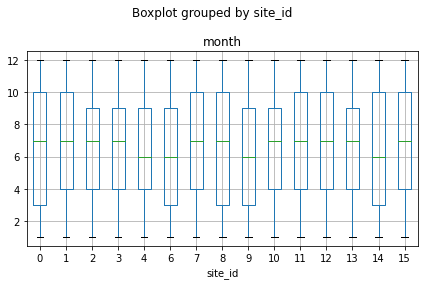

In [51]:
plot = weather_train_df.boxplot(col, by="site_id")
plt.tight_layout() 
plt.show()

<AxesSubplot:>

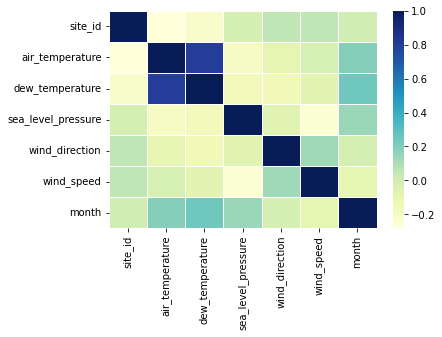

In [52]:
sb.heatmap(weather_train_df.corr(),linewidths=.5,cmap="YlGnBu")

In [53]:
##For every site there are multiple records taken in different timestamps
print(len(weather_train_df[weather_train_df['site_id'] == 0]))
print(len(weather_train_df[weather_train_df['site_id'] == 1]))
print(len(weather_train_df[weather_train_df['site_id'] == 2]))

7406
8651
6766


In [54]:
weather_train_df_t = weather_train_df.groupby(['site_id', 'month']).mean()
weather_train_df_t.reset_index()

,site_id,month,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,0,1,14.830351,9.098083,1017.830990,220.718850,4.124441
1,0,2,16.330844,8.838636,1019.960877,215.649351,4.473864
2,0,3,21.662691,14.527217,1018.487309,192.140673,4.035933
3,0,4,22.495702,14.559008,1017.275537,160.413223,4.168264
4,0,5,24.919063,17.213732,1016.040065,180.630048,3.736995
...,...,...,...,...,...,...,...
175,15,8,22.616636,17.500555,1017.525878,188.983364,3.366359
176,15,9,17.208503,12.344362,1019.955268,169.279113,3.242144
177,15,10,10.391219,6.956810,1019.793728,212.025090,4.143907
178,15,11,5.474095,1.120571,1017.960762,225.047619,4.486286


## Merge files

In [55]:
merged_df = sample_df.merge(building_df, on='building_id')
merged_df

,building_id,meter,month,meter_reading,meter_reading_log,site_id,primary_use,square_feet
0,0,electricity,1,0.238046,0.020342,0,Education,7432
1,0,electricity,2,0.000000,0.000000,0,Education,7432
2,0,electricity,3,0.000000,0.000000,0,Education,7432
3,0,electricity,4,0.112681,0.007781,0,Education,7432
4,0,electricity,5,79.768901,1.979048,0,Education,7432
...,...,...,...,...,...,...,...,...
28327,1448,electricity,8,3.301733,1.445406,15,Office,92271
28328,1448,electricity,9,3.183909,1.418563,15,Office,92271
28329,1448,electricity,10,3.327558,1.452977,15,Office,92271
28330,1448,electricity,11,3.422764,1.475920,15,Office,92271


In [56]:
merged_df = merged_df.merge(weather_train_df_t, on=['site_id', 'month'])
merged_df

,building_id,meter,month,meter_reading,meter_reading_log,site_id,primary_use,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,0,electricity,1,0.238046,0.020342,0,Education,7432,14.830351,9.098083,1017.830990,220.718850,4.124441
1,1,electricity,1,0.375049,0.057552,0,Education,2720,14.830351,9.098083,1017.830990,220.718850,4.124441
2,2,electricity,1,0.004334,0.002827,0,Education,5376,14.830351,9.098083,1017.830990,220.718850,4.124441
3,3,electricity,1,0.000000,0.000000,0,Education,23685,14.830351,9.098083,1017.830990,220.718850,4.124441
4,4,electricity,1,0.293036,0.015504,0,Education,116607,14.830351,9.098083,1017.830990,220.718850,4.124441
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27259,1444,electricity,8,5.587117,1.847838,15,Entertainment/public assembly,19619,22.616636,17.500555,1017.525878,188.983364,3.366359
27260,1445,electricity,8,4.368139,1.629809,15,Education,4298,22.616636,17.500555,1017.525878,188.983364,3.366359
27261,1446,electricity,8,3.440288,0.964705,15,Entertainment/public assembly,11265,22.616636,17.500555,1017.525878,188.983364,3.366359
27262,1447,electricity,8,180.204745,5.191935,15,Lodging/residential,29775,22.616636,17.500555,1017.525878,188.983364,3.366359


In [57]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27264 entries, 0 to 27263
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   building_id         27264 non-null  int64  
 1   meter               27264 non-null  object 
 2   month               27264 non-null  int64  
 3   meter_reading       27264 non-null  float64
 4   meter_reading_log   27264 non-null  float64
 5   site_id             27264 non-null  int64  
 6   primary_use         27264 non-null  object 
 7   square_feet         27264 non-null  int64  
 8   air_temperature     27264 non-null  float64
 9   dew_temperature     27264 non-null  float64
 10  sea_level_pressure  27264 non-null  float64
 11  wind_direction      27264 non-null  float64
 12  wind_speed          27264 non-null  float64
dtypes: float64(7), int64(4), object(2)
memory usage: 2.9+ MB


In [58]:
merged_df.shape

(27264, 13)

In [59]:
merged_df.isnull().sum()

building_id           0
meter                 0
month                 0
meter_reading         0
meter_reading_log     0
site_id               0
primary_use           0
square_feet           0
air_temperature       0
dew_temperature       0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [60]:
merged_df['site_id'].unique()

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

<AxesSubplot:>

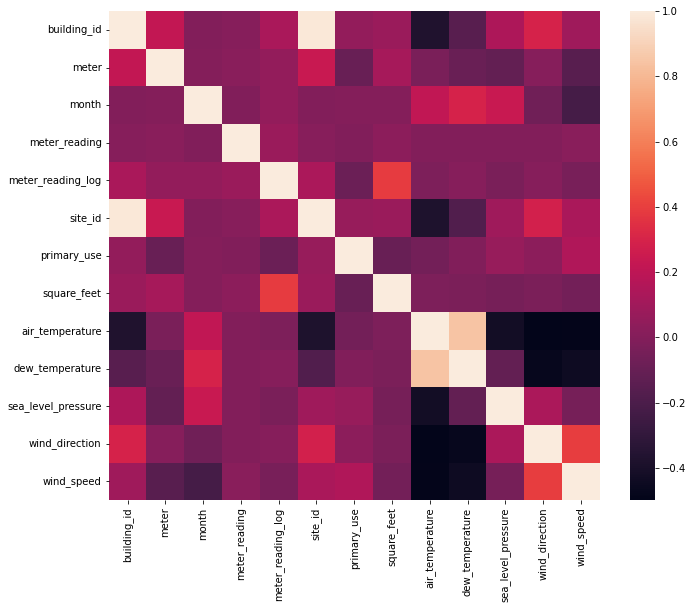

In [66]:
#Check correlation betweeen features
corr = merged_df.corr()
f, ax = plt.subplots(figsize=(11, 9))
sb.heatmap(corr)

In [67]:
merged_df['primary_use'].value_counts()

0     10831
6      6004
4      3035
1      2970
9      2265
3       540
7       332
8       293
2       156
11      155
15      155
5       144
12      132
13      120
14       84
10       48
Name: primary_use, dtype: int64

In [68]:
#Mean Of meter_reading by primary_use
merged_df.groupby('primary_use').meter_reading.agg(['mean'])

,mean
primary_use,
0,4697.473747
1,503.614831
2,305.248225
3,746.396167
4,280.290793
5,345.870377
6,530.792629
7,154.061744
8,169.008368


In [69]:
#encode columns to be able to build models for it
encoder = LabelEncoder()
merged_df['primary_use'] = encoder.fit_transform(merged_df['primary_use'])
merged_df['meter'].replace({"electricity":0, "chilledwater":1, "steam":2, "hotwater":3},inplace=True)

merged_df

,building_id,meter,month,meter_reading,meter_reading_log,site_id,primary_use,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,0,0,1,0.238046,0.020342,0,0,7432,14.830351,9.098083,1017.830990,220.718850,4.124441
1,1,0,1,0.375049,0.057552,0,0,2720,14.830351,9.098083,1017.830990,220.718850,4.124441
2,2,0,1,0.004334,0.002827,0,0,5376,14.830351,9.098083,1017.830990,220.718850,4.124441
3,3,0,1,0.000000,0.000000,0,0,23685,14.830351,9.098083,1017.830990,220.718850,4.124441
4,4,0,1,0.293036,0.015504,0,0,116607,14.830351,9.098083,1017.830990,220.718850,4.124441
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27259,1444,0,8,5.587117,1.847838,15,1,19619,22.616636,17.500555,1017.525878,188.983364,3.366359
27260,1445,0,8,4.368139,1.629809,15,0,4298,22.616636,17.500555,1017.525878,188.983364,3.366359
27261,1446,0,8,3.440288,0.964705,15,1,11265,22.616636,17.500555,1017.525878,188.983364,3.366359
27262,1447,0,8,180.204745,5.191935,15,4,29775,22.616636,17.500555,1017.525878,188.983364,3.366359


In [70]:
merged_df.to_csv("merged_df.csv", index=False)

## Kmeans clustering

In [71]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [72]:
import findspark
findspark.init()

In [73]:
import pyspark
from pyspark import SparkContext

In [74]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Clustering using K-Means').getOrCreate()

In [75]:
df = spark.read.csv('merged_df.csv', header=True, inferSchema=True)

In [76]:
df.printSchema()

root
 |-- building_id: integer (nullable = true)
 |-- meter: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- meter_reading: double (nullable = true)
 |-- meter_reading_log: double (nullable = true)
 |-- site_id: integer (nullable = true)
 |-- primary_use: integer (nullable = true)
 |-- square_feet: integer (nullable = true)
 |-- air_temperature: double (nullable = true)
 |-- dew_temperature: double (nullable = true)
 |-- sea_level_pressure: double (nullable = true)
 |-- wind_direction: double (nullable = true)
 |-- wind_speed: double (nullable = true)



In [77]:
df.columns

['building_id',
 'meter',
 'month',
 'meter_reading',
 'meter_reading_log',
 'site_id',
 'primary_use',
 'square_feet',
 'air_temperature',
 'dew_temperature',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed']

In [78]:
from pyspark.ml.feature import VectorAssembler

feature_cols = ['meter',
 'meter_reading',
 'meter_reading_log',
 'primary_use',
 'square_feet',
 'air_temperature',
 'dew_temperature',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed']
feature_vector=VectorAssembler(inputCols=feature_cols, outputCol='features')

data = feature_vector.transform(df)
final_data = feature_vector.transform(df).select('site_id', 'features')
final_data.show()

+-------+--------------------+
|site_id|            features|
+-------+--------------------+
|      0|[0.0,0.2380459074...|
|      0|[0.0,0.3750487719...|
|      0|[0.0,0.0043336860...|
|      0|[0.0,0.0,0.0,0.0,...|
|      0|[0.0,0.2930363001...|
|      0|[0.0,0.0060296819...|
|      0|[0.0,0.0,0.0,4.0,...|
|      0|[0.0,0.0,0.0,0.0,...|
|      0|[0.0,0.0,0.0,0.0,...|
|      0|[0.0,0.0,0.0,6.0,...|
|      0|[0.0,0.0,0.0,1.0,...|
|      0|[0.0,1.2737830018...|
|      0|[0.0,0.8826827225...|
|      0|[0.0,0.0,0.0,0.0,...|
|      0|[0.0,0.1815319148...|
|      0|[0.0,0.0,0.0,6.0,...|
|      0|[0.0,4.7784133574...|
|      0|[0.0,0.0,0.0,6.0,...|
|      0|[0.0,0.0,0.0,0.0,...|
|      0|[0.0,0.0,0.0,6.0,...|
+-------+--------------------+
only showing top 20 rows



In [79]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol='features',outputCol='zfeatures', withStd=True, withMean=False)

scalerModel = scaler.fit(final_data)
cluster_input_data=scalerModel.transform(final_data)
cluster_input_data.show()

+-------+--------------------+--------------------+
|site_id|            features|           zfeatures|
+-------+--------------------+--------------------+
|      0|[0.0,0.2380459074...|[0.0,1.8726701341...|
|      0|[0.0,0.3750487719...|[0.0,2.9504503626...|
|      0|[0.0,0.0043336860...|[0.0,3.4092434331...|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|      0|[0.0,0.2930363001...|[0.0,2.3052710016...|
|      0|[0.0,0.0060296819...|[0.0,4.7434570415...|
|      0|[0.0,0.0,0.0,4.0,...|[0.0,0.0,0.0,1.15...|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|      0|[0.0,0.0,0.0,6.0,...|[0.0,0.0,0.0,1.73...|
|      0|[0.0,0.0,0.0,1.0,...|[0.0,0.0,0.0,0.28...|
|      0|[0.0,1.2737830018...|[0.0,1.0020652781...|
|      0|[0.0,0.8826827225...|[0.0,6.9439277067...|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|      0|[0.0,0.1815319148...|[0.0,1.4280833433...|
|      0|[0.0,0.0,0.0,6.0,...|[0.0,0.0,0.0,1.73...|
|      0|[0.

In [80]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [81]:
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='zfeatures', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,26):
    KMeans_algo=KMeans(featuresCol='zfeatures', k=i)   
    KMeans_fit=KMeans_algo.fit(cluster_input_data)
    output=KMeans_fit.transform(cluster_input_data)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    
    print("At k = ", i , " Silhouette Score: ",score)
    
print("done")

At k =  2  Silhouette Score:  0.3214409797490168
At k =  3  Silhouette Score:  0.2850674973922551
At k =  4  Silhouette Score:  0.15110514312386997
At k =  5  Silhouette Score:  0.21848447612221364
At k =  6  Silhouette Score:  0.21706437244749027
At k =  7  Silhouette Score:  0.2459036380952505
At k =  8  Silhouette Score:  0.2204834947155503
At k =  9  Silhouette Score:  0.25393361242642204
At k =  10  Silhouette Score:  0.2564921463468423
At k =  11  Silhouette Score:  0.256377550392538
At k =  12  Silhouette Score:  0.2443107649178543
At k =  13  Silhouette Score:  0.23815495191488562
At k =  14  Silhouette Score:  0.2343121940572719
At k =  15  Silhouette Score:  0.23902010549717753
At k =  16  Silhouette Score:  0.24694042862748516
At k =  17  Silhouette Score:  0.24108913739730328
At k =  18  Silhouette Score:  0.2569357405593578
At k =  19  Silhouette Score:  0.26261293123480456
At k =  20  Silhouette Score:  0.25053129409502856
At k =  21  Silhouette Score:  0.2471209592674433

Text(0, 0.5, 'cost')

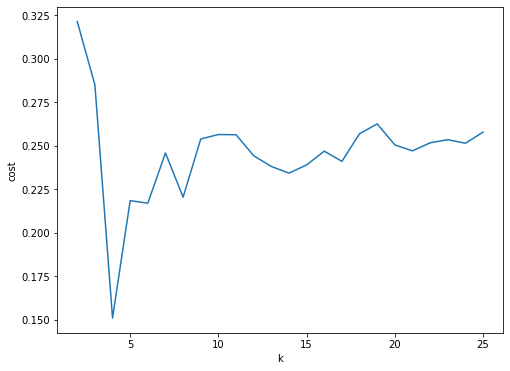

In [82]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,26),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

Th optimal number of clusters is 11

In [83]:
k=11
kmeans= KMeans(featuresCol='zfeatures', k=k)
model = kmeans.fit(cluster_input_data)

In [84]:
clust_output = model.transform(cluster_input_data)
clust_output.show(10)

+-------+--------------------+--------------------+----------+
|site_id|            features|           zfeatures|prediction|
+-------+--------------------+--------------------+----------+
|      0|[0.0,0.2380459074...|[0.0,1.8726701341...|         1|
|      0|[0.0,0.3750487719...|[0.0,2.9504503626...|         1|
|      0|[0.0,0.0043336860...|[0.0,3.4092434331...|         1|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|         1|
|      0|[0.0,0.2930363001...|[0.0,2.3052710016...|         1|
|      0|[0.0,0.0060296819...|[0.0,4.7434570415...|         1|
|      0|[0.0,0.0,0.0,4.0,...|[0.0,0.0,0.0,1.15...|         1|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|         1|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|         1|
|      0|[0.0,0.0,0.0,6.0,...|[0.0,0.0,0.0,1.73...|         1|
+-------+--------------------+--------------------+----------+
only showing top 10 rows



In [87]:
clust_output.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 2718|
|         6|    4|
|         3| 2998|
|         5| 3219|
|         9| 4104|
|         4| 2055|
|         8| 2483|
|         7| 2491|
|        10| 1104|
|         2| 1981|
|         0| 4107|
+----------+-----+



In [88]:
rows = clust_output.collect()
df_pred = spark.createDataFrame(rows)
df_pred.show()

+-------+--------------------+--------------------+----------+
|site_id|            features|           zfeatures|prediction|
+-------+--------------------+--------------------+----------+
|      0|[0.0,0.2380459074...|[0.0,1.8726701341...|         1|
|      0|[0.0,0.3750487719...|[0.0,2.9504503626...|         1|
|      0|[0.0,0.0043336860...|[0.0,3.4092434331...|         1|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|         1|
|      0|[0.0,0.2930363001...|[0.0,2.3052710016...|         1|
|      0|[0.0,0.0060296819...|[0.0,4.7434570415...|         1|
|      0|[0.0,0.0,0.0,4.0,...|[0.0,0.0,0.0,1.15...|         1|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|         1|
|      0|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|         1|
|      0|[0.0,0.0,0.0,6.0,...|[0.0,0.0,0.0,1.73...|         1|
|      0|[0.0,0.0,0.0,1.0,...|[0.0,0.0,0.0,0.28...|         1|
|      0|[0.0,1.2737830018...|[0.0,1.0020652781...|         1|
|      0|[0.0,0.8826827225...|[0.0,6.9439277067...|    

In [89]:
df_pred.printSchema()

root
 |-- site_id: long (nullable = true)
 |-- features: vector (nullable = true)
 |-- zfeatures: vector (nullable = true)
 |-- prediction: long (nullable = true)



In [90]:
X = df_pred.rdd.map(lambda x:[float(y) for y in x['features']]).toDF(feature_cols)

In [91]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

df_pred = df_pred.drop("features", "zfeatures")
df_pred = df_pred.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
X = X.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

final_pred_df = X.join(df_pred, on=["row_index"]).drop("row_index")
final_pred_df.show()

+-----+--------------------+--------------------+-----------+-----------+-----------------+----------------+------------------+-----------------+----------------+-------+----------+
|meter|       meter_reading|   meter_reading_log|primary_use|square_feet|  air_temperature| dew_temperature|sea_level_pressure|   wind_direction|      wind_speed|site_id|prediction|
+-----+--------------------+--------------------+-----------+-----------+-----------------+----------------+------------------+-----------------+----------------+-------+----------+
|  0.0| 0.23804590747330961|0.020341777673783968|        0.0|     7432.0|14.83035143769968|9.09808306709265|1017.8309904153354|220.7188498402556|4.12444089456869|      0|         1|
|  0.0|  0.3750487719298246|0.057552310581881094|        0.0|     2720.0|14.83035143769968|9.09808306709265|1017.8309904153354|220.7188498402556|4.12444089456869|      0|         1|
|  0.0|  0.0043336860670194|0.002826714587763...|        0.0|     5376.0|14.83035143769968

## SparkML preprocessing

In [92]:
final_pred_df = final_pred_df.drop("meter_reading")

In [93]:
feature_cols = ['meter',
 'site_id',
 'primary_use',
 'square_feet',
 'air_temperature',
 'dew_temperature',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed']

feature_vector=VectorAssembler(inputCols=feature_cols, outputCol='features')

models_data = feature_vector.transform(final_pred_df).select('meter_reading_log', 'features', 'prediction')
models_data.show()

+--------------------+--------------------+----------+
|   meter_reading_log|            features|prediction|
+--------------------+--------------------+----------+
|0.020341777673783968|[0.0,0.0,0.0,7432...|         1|
|0.057552310581881094|[0.0,0.0,0.0,2720...|         1|
|0.002826714587763...|[0.0,0.0,0.0,5376...|         1|
|                 0.0|[0.0,0.0,0.0,2368...|         1|
|0.015503769482135842|[0.0,0.0,0.0,1166...|         1|
|0.003401964355014...|[0.0,0.0,0.0,8000...|         1|
|                 0.0|[0.0,0.0,4.0,2792...|         1|
|                 0.0|[0.0,0.0,0.0,1210...|         1|
|                 0.0|[0.0,0.0,0.0,6080...|         1|
|                 0.0|[0.0,0.0,6.0,2700...|         1|
|                 0.0|[0.0,0.0,1.0,3707...|         1|
| 0.05179606872298952|[0.0,0.0,0.0,4907...|         1|
| 0.05235190489760043|[0.0,0.0,4.0,3710...|         1|
|                 0.0|[0.0,0.0,0.0,9938...|         1|
|0.008224202502168246|[0.0,0.0,0.0,8625...|         1|
|         

In [94]:
models_data_clusers = models_data.filter((models_data.prediction == 2) | (models_data.prediction == 5) | (models_data.prediction == 3) | (models_data.prediction == 1) | (models_data.prediction == 10) )
models_data_clusers.show()

+--------------------+--------------------+----------+
|   meter_reading_log|            features|prediction|
+--------------------+--------------------+----------+
|0.020341777673783968|[0.0,0.0,0.0,7432...|         1|
|0.057552310581881094|[0.0,0.0,0.0,2720...|         1|
|0.002826714587763...|[0.0,0.0,0.0,5376...|         1|
|                 0.0|[0.0,0.0,0.0,2368...|         1|
|0.015503769482135842|[0.0,0.0,0.0,1166...|         1|
|0.003401964355014...|[0.0,0.0,0.0,8000...|         1|
|                 0.0|[0.0,0.0,4.0,2792...|         1|
|                 0.0|[0.0,0.0,0.0,1210...|         1|
|                 0.0|[0.0,0.0,0.0,6080...|         1|
|                 0.0|[0.0,0.0,6.0,2700...|         1|
|                 0.0|[0.0,0.0,1.0,3707...|         1|
| 0.05179606872298952|[0.0,0.0,0.0,4907...|         1|
| 0.05235190489760043|[0.0,0.0,4.0,3710...|         1|
|                 0.0|[0.0,0.0,0.0,9938...|         1|
|0.008224202502168246|[0.0,0.0,0.0,8625...|         1|
|         

In [95]:
models_data_clusers.count()

12020

In [97]:
train, test = models_data_clusers.drop('prediction').randomSplit(weights=[0.8,0.2], seed=200)

## Gradient-boosted tree regression

In [98]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'meter_reading_log', maxIter=10)
gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(test)
gbt_predictions.select('prediction', 'meter_reading_log', 'features').show(5)

+-------------------+-----------------+--------------------+
|         prediction|meter_reading_log|            features|
+-------------------+-----------------+--------------------+
| 1.7990811905407487|              0.0|[0.0,0.0,0.0,7432...|
|0.02914316421639348|              0.0|[0.0,0.0,0.0,8157...|
|0.18166336232085648|              0.0|[0.0,0.0,0.0,1055...|
|0.18166336232085648|              0.0|[0.0,0.0,0.0,1118...|
|0.18166336232085648|              0.0|[0.0,0.0,0.0,1210...|
+-------------------+-----------------+--------------------+
only showing top 5 rows



In [99]:
from pyspark.ml.evaluation import RegressionEvaluator
gbt_evaluator = RegressionEvaluator(labelCol="meter_reading_log", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.20376


## Multiple Linear Regression (MLR)

In [100]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='meter_reading_log', regParam=0.3, elasticNetParam=0.8)

lr_model = lr.fit(train)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.0,0.0,4.096959533788507e-06,0.007466099118535481,0.0,0.0,0.0,0.0]
Intercept: 3.4409809634362665


In [101]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 1.676094
r2: 0.207569


In [102]:
trainingSummary.residuals.show()

+-------------------+
|          residuals|
+-------------------+
| -3.577530713169246|
|-3.5849339190468017|
|-3.6247420170519007|
| -3.593357267848271|
|-3.5964937988562236|
| -3.607696626216531|
|-3.6487423237906285|
|-3.6599451511509358|
|-3.6997532491560343|
| -3.800837849522993|
|   -3.8120406768833|
|-3.8518487748883987|
| -3.805324020212491|
|-3.8165268475727987|
|-3.8563349455778972|
| -3.883321935816757|
|-3.8945247631770643|
| -3.934332861182163|
|-3.8859194081611785|
| -3.936930333526585|
+-------------------+
only showing top 20 rows



In [103]:
lr_predictions = lr_model.transform(test)
lr_predictions.select("prediction","meter_reading_log","features").filter(lr_predictions.meter_reading_log != 0).show()

+------------------+--------------------+--------------------+
|        prediction|   meter_reading_log|            features|
+------------------+--------------------+--------------------+
| 3.764902866424482|6.679274970334063E-5|[1.0,10.0,0.0,673...|
|  4.97151384670671|3.124909243876173E-4|[1.0,7.0,0.0,3875...|
| 4.014688586303081|0.001963689055481...|[0.0,0.0,0.0,1102...|
| 3.657376836360032|0.002001303513951826|[1.0,2.0,0.0,4314...|
|3.6475047242216294|0.002217101274511...|[0.0,0.0,0.0,1093...|
| 3.579291371351858|0.003577218476196025|[1.0,6.0,0.0,3053...|
| 3.616274625063367|0.003630742711091...|[1.0,6.0,0.0,3955...|
|3.5917635505896275|0.004383322379816899|[0.0,0.0,6.0,7043...|
| 3.699886866987059|0.004430630825034128|[2.0,6.0,0.0,5365...|
| 3.672666667844568|0.004430630825034128|[2.0,6.0,4.0,4700...|
|3.5663278858089384|0.005483379224406349|[0.0,0.0,0.0,3569...|
|3.7134448811397145|0.006975613736425143|[0.0,1.0,0.0,3220...|
| 4.079750660664247| 0.00903853647417496|[0.0,0.0,0.0,1

In [104]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", 
                 labelCol="meter_reading_log",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.222815


## Decision tree regression

In [105]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'meter_reading_log')
dt_model = dt.fit(train)

In [106]:
dt_predictions = dt_model.transform(test)
dt_predictions.select("prediction","meter_reading_log","features").filter(lr_predictions.meter_reading_log != 0).show()

+--------------------+--------------------+--------------------+
|          prediction|   meter_reading_log|            features|
+--------------------+--------------------+--------------------+
|  1.8256741477105678|6.679274970334063E-5|[1.0,10.0,0.0,673...|
|  6.0719977598255745|3.124909243876173E-4|[1.0,7.0,0.0,3875...|
| 0.02676660236476408|0.001963689055481...|[0.0,0.0,0.0,1102...|
|  1.6898924152521901|0.002001303513951826|[1.0,2.0,0.0,4314...|
|   2.868174282143816|0.002217101274511...|[0.0,0.0,0.0,1093...|
|  1.8256741477105678|0.003577218476196025|[1.0,6.0,0.0,3053...|
|  1.8256741477105678|0.003630742711091...|[1.0,6.0,0.0,3955...|
|8.165322555904403E-4|0.004383322379816899|[0.0,0.0,6.0,7043...|
|  1.8256741477105678|0.004430630825034128|[2.0,6.0,0.0,5365...|
|  1.8256741477105678|0.004430630825034128|[2.0,6.0,4.0,4700...|
|  1.6898924152521901|0.005483379224406349|[0.0,0.0,0.0,3569...|
|   3.751533033237603|0.006975613736425143|[0.0,1.0,0.0,3220...|
|0.040039986150664474| 0.

In [107]:
dt_evaluator = RegressionEvaluator(
    labelCol="meter_reading_log", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.28935


In [108]:
dt_model.featureImportances

SparseVector(9, {0: 0.1131, 1: 0.0773, 2: 0.019, 3: 0.5491, 4: 0.1836, 5: 0.0046, 6: 0.0075, 7: 0.0022, 8: 0.0436})

In [109]:
train.take(1)

[Row(meter_reading_log=0.0, features=DenseVector([0.0, 0.0, 0.0, 3569.0, 16.3308, 8.8386, 1019.9609, 215.6494, 4.4739]))]

In [110]:
test.take(1)

[Row(meter_reading_log=0.0, features=DenseVector([0.0, 0.0, 0.0, 7432.0, 21.6627, 14.5272, 1018.4873, 192.1407, 4.0359]))]

In [111]:
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

br = GeneralizedLinearRegression(family="gaussian", link="identity", regParam=0.3, labelCol='meter_reading_log', featuresCol="features")
br_model = br.fit(train)
predictions = br_model.transform(test)

br_evaluator = RegressionEvaluator(labelCol='meter_reading_log', predictionCol='prediction', metricName='r2')
r2 = br_evaluator.evaluate(predictions)
print("R Squared (R2) on test data = %g" % r2)

R Squared (R2) on test data = 0.273015


## Random Forest Regression


In [113]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features",labelCol='meter_reading_log')
rf_model = rf.fit(train)

In [114]:
rf_predictions = rf_model.transform(test)
rf_predictions.select('prediction', 'meter_reading_log', 'features').show(5)

+------------------+-----------------+--------------------+
|        prediction|meter_reading_log|            features|
+------------------+-----------------+--------------------+
|1.2280928848293875|              0.0|[0.0,0.0,0.0,7432...|
|0.9624380956661319|              0.0|[0.0,0.0,0.0,8157...|
|  1.09087326786909|              0.0|[0.0,0.0,0.0,1055...|
|  1.09087326786909|              0.0|[0.0,0.0,0.0,1118...|
|  1.09087326786909|              0.0|[0.0,0.0,0.0,1210...|
+------------------+-----------------+--------------------+
only showing top 5 rows



In [115]:
from pyspark.ml.evaluation import RegressionEvaluator
rf_evaluator = RegressionEvaluator(labelCol="meter_reading_log", predictionCol="prediction", metricName="rmse")
rmse = rf_evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.31473


## Results

| ML Method| Root Mean Squared Error (RMSE) |
| ---                 | ---                |
|    Gradient-boosted tree regression                 |      1.09844              |
| Multiple Linear regression                |      1.660778              | 
|          Decision tree regression           |          1.20964          |
|Random Forest Regression             | 1.31473   |

The best model out of the three is the Gradient Boosted Tree model. On the other hand, the worst model is the Multiple Linear Regression model.